# CMA/ES PER SUBJECT - 4 try: EM fits Scaled

Latest for thesis

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
import io
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sys
from IPython.utils import io

from experimentlauncher import ExperimentLauncher
from dataio import DataIO
import plots_experimental_data
import em_circularmixture_parametrickappa

import progress

# import matplotlib.animation as plt_anim
from mpl_toolkits.mplot3d import Axes3D

import glob
import re
import inspect
import imp

import utils
# import submitpbs
import load_experimental_data

from plots_fitexperiment_papertheo import PlotsFitExperimentAllTPaperTheo

oldstdout = None

## Reload data

In [3]:
%cd /nfs/data3/lmatthey/visual_working_mem/fitexperiment_subject_cmaes_08_2016/4try_b09_emfit/

metric = 'dist_emfit_scaled'
folder_pattern = "cmaes_subjects_bays09_emfitscaled_4try_Mratiosigmaxsigmabaselinelapserate_subject*"
re_subject = re.compile(".*subject([0-9]*)rep")

df_all_fits = None

for filename in glob.glob("./%s/outputs/cmaes_alliter_tracking*.npy" % folder_pattern):
    found = re_subject.match(filename)
    subject = int(found.group(1))
    print "Reloading data of Subject %d" % subject
    
    curr_cmaes_trace = np.load(filename).item()

    candidates_parameters = np.array(curr_cmaes_trace['candidates'])
    fitness = np.array(curr_cmaes_trace['fitness'])
    parameter_names_sorted = curr_cmaes_trace['parameter_names_sorted']
    
    df_fits_subject = pd.DataFrame.from_items([('step', np.arange(fitness.size)), 
                                               ('experiment_subject', subject),
                                               (metric, np.ma.masked_greater(fitness.flatten(), 1e8))] + 
                                               [(param, candidates_parameters[:, param_i]) 
                                                    for param_i, param in enumerate(parameter_names_sorted)])
    
    if df_all_fits is None:
        df_all_fits = df_fits_subject
    else:
        df_all_fits = df_all_fits.append(df_fits_subject, ignore_index=True)
        
df_all_fits = df_all_fits.sort_values(by=['experiment_subject', 'step'])
subject_space = np.sort(df_all_fits['experiment_subject'].unique())

parameter_names_sorted

/nfs/data3/lmatthey/visual_working_mem/fitexperiment_subject_cmaes_08_2016/4try_b09_emfit
Reloading data of Subject 6
Reloading data of Subject 10
Reloading data of Subject 8
Reloading data of Subject 7
Reloading data of Subject 12
Reloading data of Subject 4
Reloading data of Subject 3
Reloading data of Subject 11
Reloading data of Subject 2
Reloading data of Subject 9
Reloading data of Subject 5
Reloading data of Subject 1


['M', 'lapse_rate', 'ratio_conj', 'sigma_baseline', 'sigmax']

In [4]:
# Fix M and ratio_conj
M_corrected, ratio_corrected = utils.fix_M_ratioconj(df_all_fits['M'], df_all_fits['ratio_conj'])
df_all_fits.loc[:, 'M'] = M_corrected
df_all_fits.loc[:, 'ratio_conj'] = ratio_corrected

In [5]:
df_all_fits.loc[:, metric + "_log"] = np.log(df_all_fits[metric])
df_all_fits.loc[:, metric + "_log10"] = np.log10(df_all_fits[metric])

In [6]:
# Filter rows where LL > cutoff value and remove lapse_rate > cutoff
LL_max_cutoff = 2000
df_best_fits = df_all_fits[df_all_fits[metric] < LL_max_cutoff]

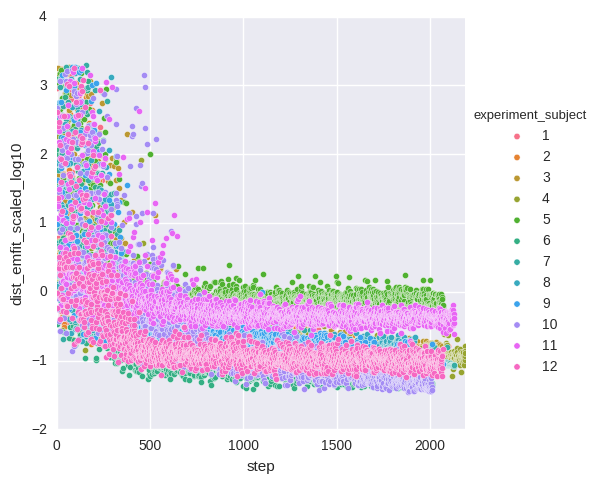

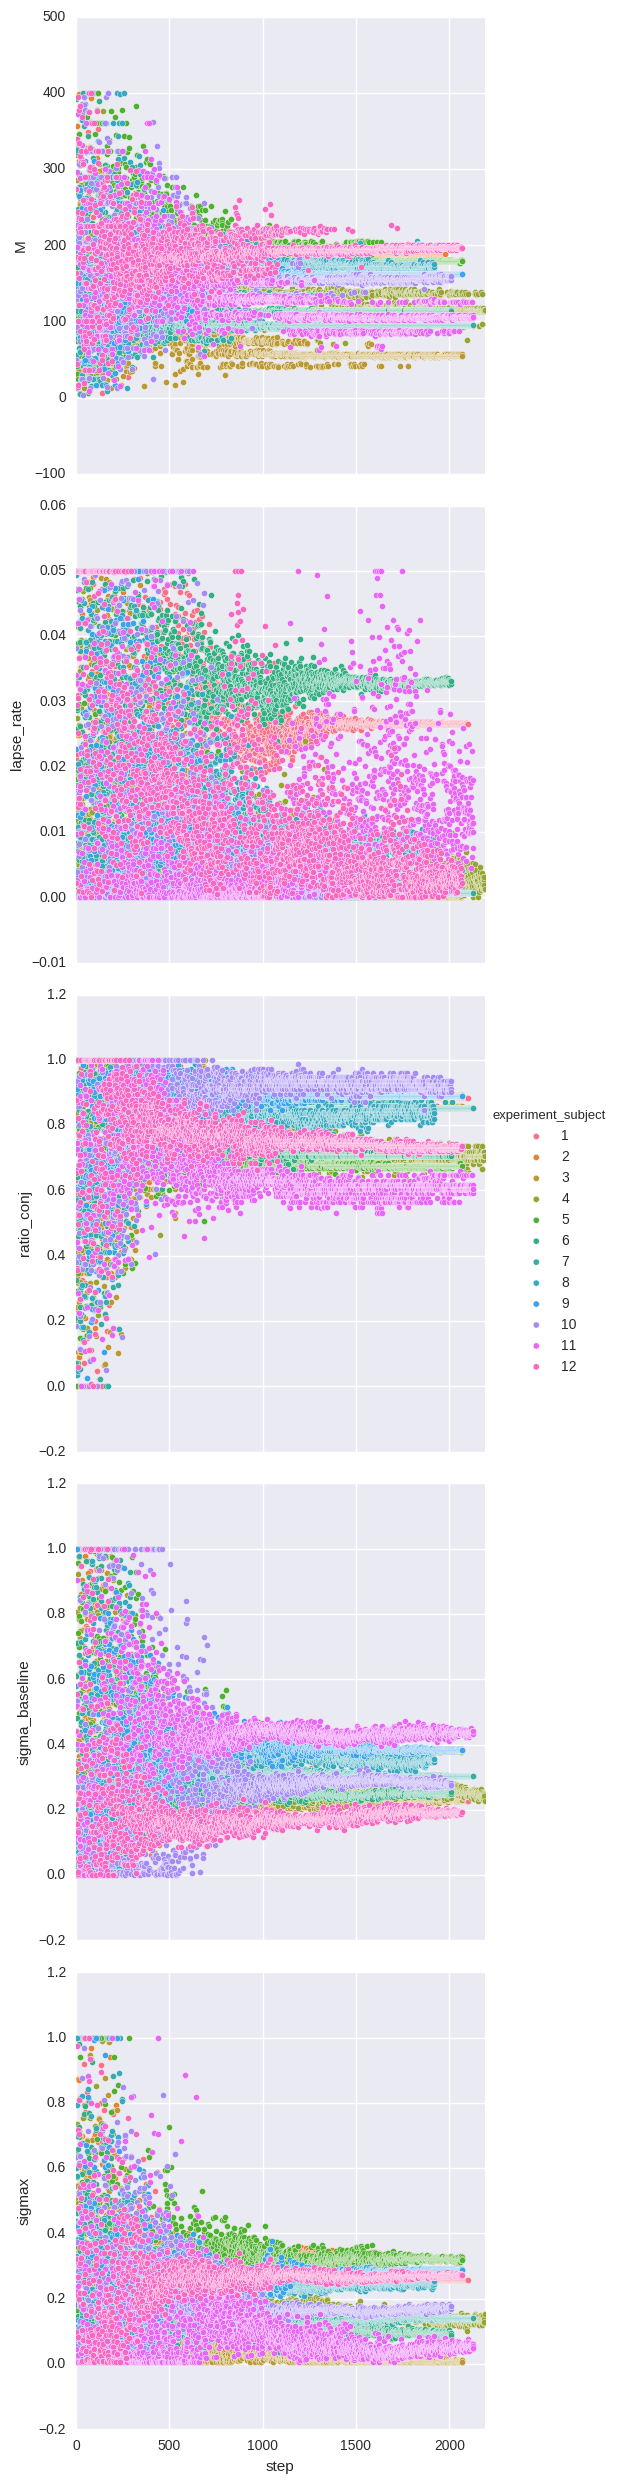

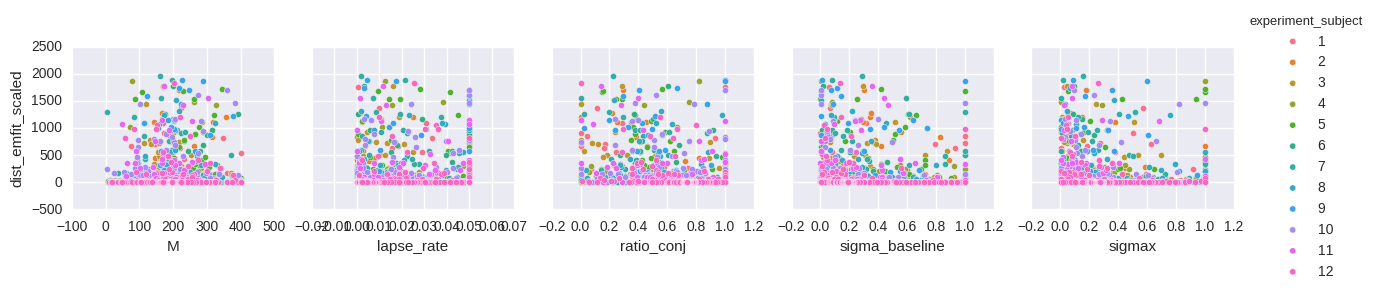

In [7]:
# Learning curve
g = sns.pairplot(df_best_fits,
                 y_vars=[metric + "_log10"],
                 x_vars=['step'],
                 hue='experiment_subject',
                 size=5,
                )

g.set(xlim=(-1, df_best_fits['step'].max())
)

# Check training of parameters
g = sns.pairplot(df_best_fits,
                 y_vars=parameter_names_sorted,
                 x_vars=['step'],
                 hue='experiment_subject',
                 size=5
                )
g.set(xlim=(-1, df_best_fits['step'].max()))

# Check parameters effects
sns.pairplot(df_best_fits,
             x_vars=parameter_names_sorted,
             y_vars=[metric],
             hue='experiment_subject',
            )


## Check parameters values obtained

In [8]:
df_topparams = df_best_fits.groupby('experiment_subject').apply(
    lambda subDf: subDf.sort_values('step', ascending=False).head(30).describe().loc[['50%', 'std'], parameter_names_sorted + [metric]]
)
df_topparams

M  lapse_rate    ratio_conj  sigma_baseline  \
experiment_subject                                                             
1                  50%  137.000000    0.026590  8.832117e-01        0.226600   
                   std    0.000000    0.000051  5.646013e-16        0.000071   
2                  50%  189.000000    0.000036  8.941799e-01        0.252342   
                   std    0.691492    0.000063  3.237267e-03        0.001954   
3                  50%   55.000000    0.000179  8.909091e-01        0.232423   
                   std    0.860366    0.000343  1.344751e-02        0.002871   
4                  50%  115.000000    0.001917  7.043478e-01        0.245005   
                   std    7.745670    0.000982  1.440964e-02        0.007983   
5                  50%  179.000000    0.001120  6.759777e-01        0.382597   
                   std    0.827682    0.000198  3.120356e-03        0.002102   
6                  50%  113.000000    0.033059  7.168142e-01        0.251311   
                   std    0.958927    0.000265  5.977149e-03        0.002954   
7                  50%   95.000000    0.000680  8.526316e-01        0.303979   
                   std    0.000000    0.000036  2.258405e-16        0.000342   
8                  50%  172.000000    0.008265  8.372093e-01        0.355508   
                   std    2.558735    0.000768  1.239716e-02        0.005515   
9                  50%  162.000000    0.004282  8.888889e-01        0.383860   
                   std    0.000000    0.000052  3.387608e-16        0.001108   
10                 50%  158.000000    0.001115  9.113924e-01        0.279972   
                   std    1.946408    0.000181  1.137886e-02        0.004226   
11                 50%  106.000000    0.011385  6.037736e-01        0.435438   
                   std    6.744602    0.004370  1.663898e-02        0.005741   
12                 50%  198.000000    0.002548  7.272727e-01        0.191659   
                   std    1.126484    0.000964  4.167250e-03        0.002894   

                          sigmax  dist_emfit_scaled  
experiment_subject                                   
1                  50%  0.256890           0.161432  
                   std  0.000055           0.001138  
2                  50%  0.320741           0.083074  
                   std  0.001849           0.002478  
3                  50%  0.008495           0.128087  
                   std  0.002262           0.015919  
4                  50%  0.134264           0.117503  
                   std  0.008347           0.019693  
5                  50%  0.318495           0.650999  
                   std  0.005143           0.125218  
6                  50%  0.092306           0.049610  
                   std  0.004133           0.016807  
7                  50%  0.141091           0.085615  
                   std  0.000674           0.001416  
8                  50%  0.247847           0.132126  
                   std  0.006338           0.035243  
9                  50%  0.288304           0.088833  
                   std  0.000903           0.004174  
10                 50%  0.172883           0.039755  
                   std  0.004132           0.006978  
11                 50%  0.056111           0.436838  
                   std  0.006008           0.090535  
12                 50%  0.273807           0.095501  
                   std  0.002368           0.025313

In [9]:
subject_space_sorted = df_topparams.reset_index().sort_values('dist_emfit_scaled')['experiment_subject'].values
subject_space_sorted

array([ 1,  7,  2,  9, 10,  3,  6,  4, 12,  8, 10,  6,  2,  7,  9, 11, 12,
        4,  5,  3,  8,  1, 11,  5])

In [10]:
df_bestparams_subjects = df_best_fits.groupby('experiment_subject').apply(
#     lambda subDf: subDf.sort_values(metric, ascending=True).head(1).median()
    lambda subDf: subDf.sort_values('step', ascending=False).head(1).median()
)
df_bestparams_subjects

step  experiment_subject  dist_emfit_scaled      M  \
experiment_subject                                                         
1                   2098.0                 1.0           0.165148  137.0   
2                   1979.0                 2.0           0.083806  189.0   
3                   2069.0                 3.0           0.124533   55.0   
4                   2189.0                 4.0           0.129634  115.0   
5                   2069.0                 5.0           0.634774  179.0   
6                   2009.0                 6.0           0.043876  113.0   
7                   2129.0                 7.0           0.085137   95.0   
8                   1919.0                 8.0           0.145886  176.0   
9                   2069.0                 9.0           0.089227  162.0   
10                  2009.0                10.0           0.037006  160.0   
11                  2129.0                11.0           0.415120  106.0   
12                  2069.0                12.0           0.146388  196.0   

                    lapse_rate  ratio_conj  sigma_baseline    sigmax  \
experiment_subject                                                     
1                     0.026515    0.883212        0.226457  0.256947   
2                     0.000107    0.894180        0.249487  0.320871   
3                     0.000463    0.890909        0.230750  0.006298   
4                     0.001298    0.704348        0.226389  0.153606   
5                     0.001176    0.675978        0.382630  0.318632   
6                     0.033193    0.716814        0.254488  0.088079   
7                     0.000708    0.852632        0.303596  0.141882   
8                     0.007961    0.818182        0.355794  0.254770   
9                     0.004230    0.888889        0.384823  0.288110   
10                    0.001300    0.900000        0.275357  0.177221   
11                    0.011384    0.603774        0.440497  0.048517   
12                    0.002131    0.734694        0.193166  0.272060   

                    dist_emfit_scaled_log  dist_emfit_scaled_log10  
experiment_subject                                                  
1                               -1.800912                -0.782126  
2                               -2.479254                -1.076726  
3                               -2.083186                -0.904716  
4                               -2.043044                -0.887283  
5                               -0.454486                -0.197381  
6                               -3.126377                -1.357768  
7                               -2.463494                -1.069882  
8                               -1.924928                -0.835985  
9                               -2.416577                -1.049506  
10                              -3.296673                -1.431727  
11                              -0.879186                -0.381826  
12                              -1.921497                -0.834496

In [11]:
params_mean = df_bestparams_subjects.mean()
params_std = df_bestparams_subjects.std()

for param in parameter_names_sorted:
    print("%s   %.3g +- %.3g" % (param, params_mean[param], params_std[param]))

M   140 +- 43.7
lapse_rate   0.00754 +- 0.0111
ratio_conj   0.797 +- 0.104
sigma_baseline   0.294 +- 0.079
sigmax   0.194 +- 0.107


In [12]:
best_params_subj = df_bestparams_subjects.sort_values('dist_emfit_scaled')[
    ['experiment_subject'] + parameter_names_sorted + [metric]].reset_index(drop=True)
print(best_params_subj.to_latex())
# best_params_subj

\begin{tabular}{lrrrrrrr}
\toprule
{} &  experiment\_subject &      M &  lapse\_rate &  ratio\_conj &  sigma\_baseline &    sigmax &  dist\_emfit\_scaled \\
\midrule
0  &                10.0 &  160.0 &    0.001300 &    0.900000 &        0.275357 &  0.177221 &           0.037006 \\
1  &                 6.0 &  113.0 &    0.033193 &    0.716814 &        0.254488 &  0.088079 &           0.043876 \\
2  &                 2.0 &  189.0 &    0.000107 &    0.894180 &        0.249487 &  0.320871 &           0.083806 \\
3  &                 7.0 &   95.0 &    0.000708 &    0.852632 &        0.303596 &  0.141882 &           0.085137 \\
4  &                 9.0 &  162.0 &    0.004230 &    0.888889 &        0.384823 &  0.288110 &           0.089227 \\
5  &                 3.0 &   55.0 &    0.000463 &    0.890909 &        0.230750 &  0.006298 &           0.124533 \\
6  &                 4.0 &  115.0 &    0.001298 &    0.704348 &        0.226389 &  0.153606 &           0.129634 \\
7  &                 8

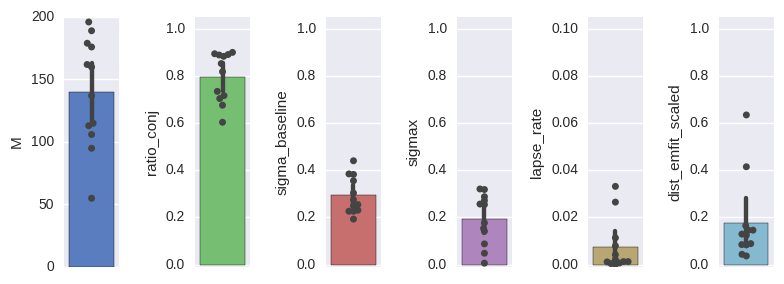

In [41]:
# df_best_params_meld = pd.melt(df_bestparams_subjects, id_vars=['experiment_subject', 'step', 'dist_nll'])
parameter_names_sorted = ['M', 'ratio_conj', 'sigma_baseline', 'sigmax', 'lapse_rate', metric]
colors = sns.color_palette('muted', n_colors=len(parameter_names_sorted))
fig_parameters, axes = plt.subplots(1, len(parameter_names_sorted), figsize=(8, 3))
axes = axes.flatten()
for i, param in enumerate(parameter_names_sorted):
    sns.barplot(df_bestparams_subjects[param], orient='v', ax=axes[i], color=colors[i])
    sns.swarmplot(df_bestparams_subjects[param], orient='v', ax=axes[i], color='#444444')

axes[0].set_ylim((-0.02, 200))
for ax in axes[1:-2]:
    ax.set_ylim((-0.01, 1.05))
axes[-2].set_ylim((-0.001, 0.105))
axes[-1].set_ylim((-0.01, 1.05))
fig_parameters.set_tight_layout(True)


## Get plots for all subjects, and associated EM fits

In [14]:
experiment_parameters = dict(action_to_do='launcher_do_fitexperiment_subject_allmetrics',
                             inference_method='sample',
                             experiment_id='bays09',
                             selection_method='last',
                             renormalize_sigma=None,
                             sigmay=0.00001,
                             num_samples=10,
                             code_type='mixed',
                             slice_width=0.07,
                             burn_samples=10,
                             ratio_conj=0.7,
                             stimuli_generation_recall='random',
                             autoset_parameters=None,
                             )

all_results = dict()
all_plots_fit_exp = dict()

for subject in progress.ProgressDisplay(subject_space):
    print "FitExperimentAllTSubject for subject %d" % subject

    experiment_parameters.update(df_bestparams_subjects.loc[subject])
    for key in ['M', 'experiment_subject']:
        experiment_parameters[key] = int(experiment_parameters[key])
    
    with io.capture_output() as captured:
        experiment_launcher = ExperimentLauncher(run=True, arguments_dict=experiment_parameters)
        fit_exp = experiment_launcher.all_vars['fit_exp']
        all_results[subject] = experiment_launcher.all_vars['all_outputs_data']
        all_plots_fit_exp[subject] = PlotsFitExperimentAllTPaperTheo(fit_exp)
        

[0%] --
FitExperimentAllTSubject for subject 1
[8%] 14m49s
FitExperimentAllTSubject for subject 2
[16%] 13m48s
FitExperimentAllTSubject for subject 3
[25%] 12m4s
FitExperimentAllTSubject for subject 4
[33%] 10m23s
FitExperimentAllTSubject for subject 5
[41%] 9m16s
FitExperimentAllTSubject for subject 6
[50%] 8m6s
FitExperimentAllTSubject for subject 7
[58%] 6m40s
FitExperimentAllTSubject for subject 8
[66%] 5m29s
FitExperimentAllTSubject for subject 9
[75%] 4m11s
FitExperimentAllTSubject for subject 10
[83%] 2m57s
FitExperimentAllTSubject for subject 11
[91%] 1m25s
FitExperimentAllTSubject for subject 12
[100%] 16m9s


In [15]:
dist_emfitscaled_subjects = np.array([np.nansum(results['result_emfit_mse_scaled']) 
                                      for sub, results in all_results.iteritems()])
subject_space_sorted_bis = np.argsort(dist_emfitscaled_subjects) + 1

[0%] --
Subject 12
[8%] 8s
Subject 8
[16%] 7s
Subject 10
[25%] 6s
Subject 9
[33%] 5s
Subject 7
[41%] 5s
Subject 3
[50%] 4s
Subject 6
[58%] 3s
Subject 4
[66%] 3s
Subject 2
[75%] 2s
Subject 1
[83%] 1s
Subject 5
[91%] 1s
Subject 11
[100%] 8s


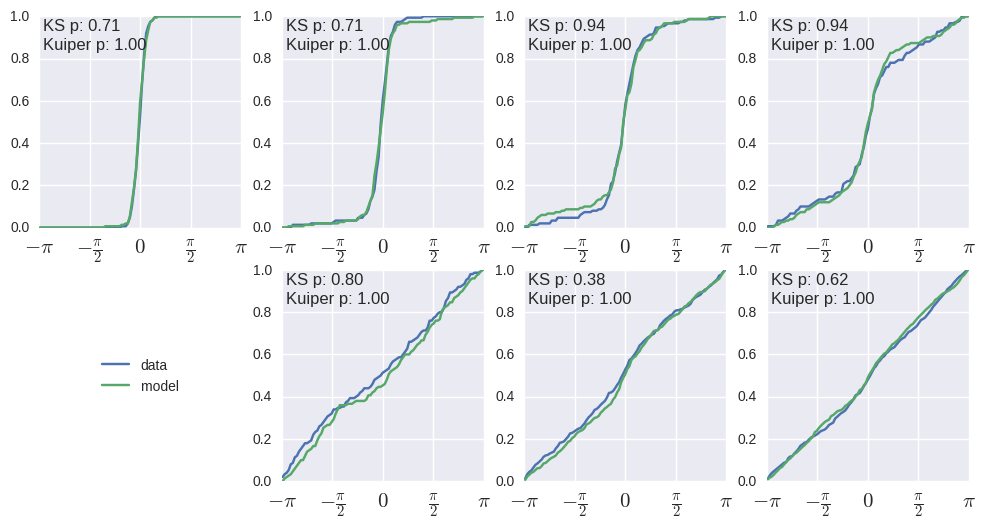

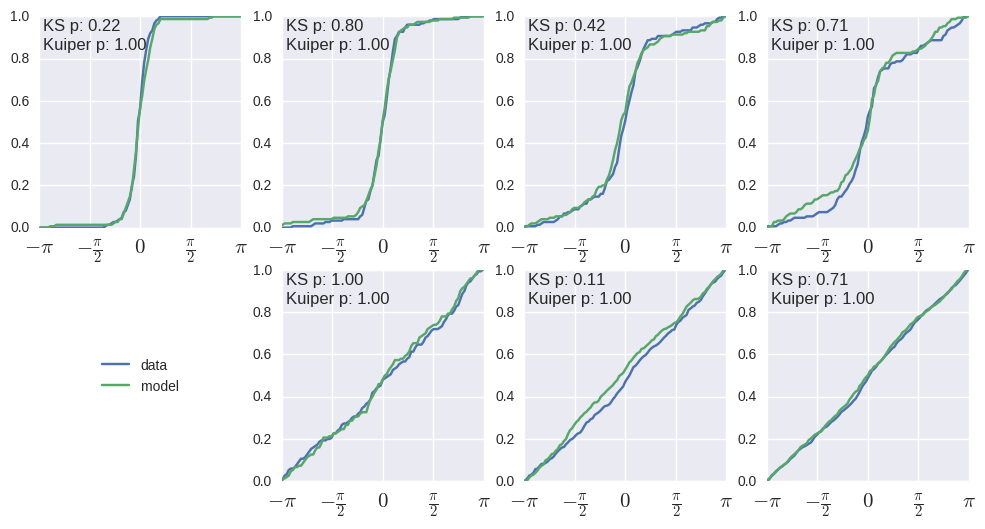

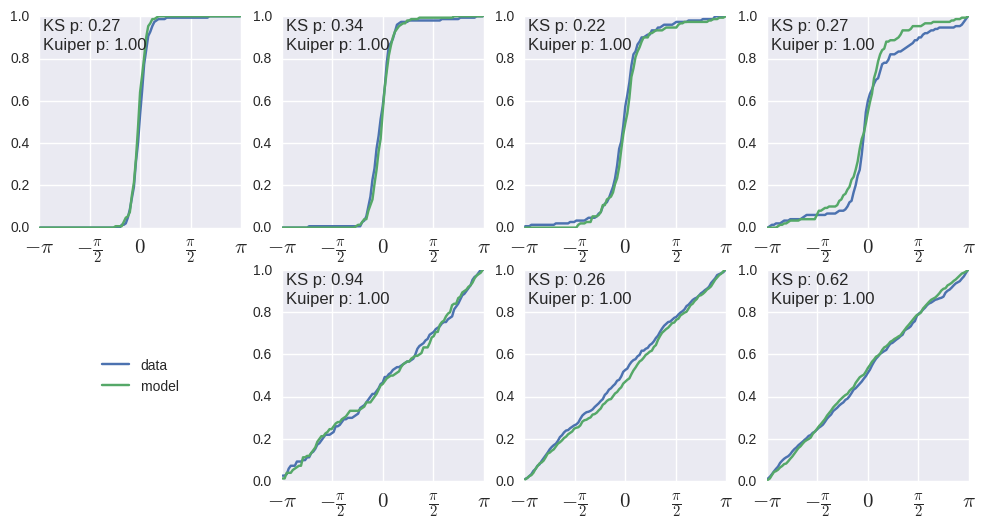

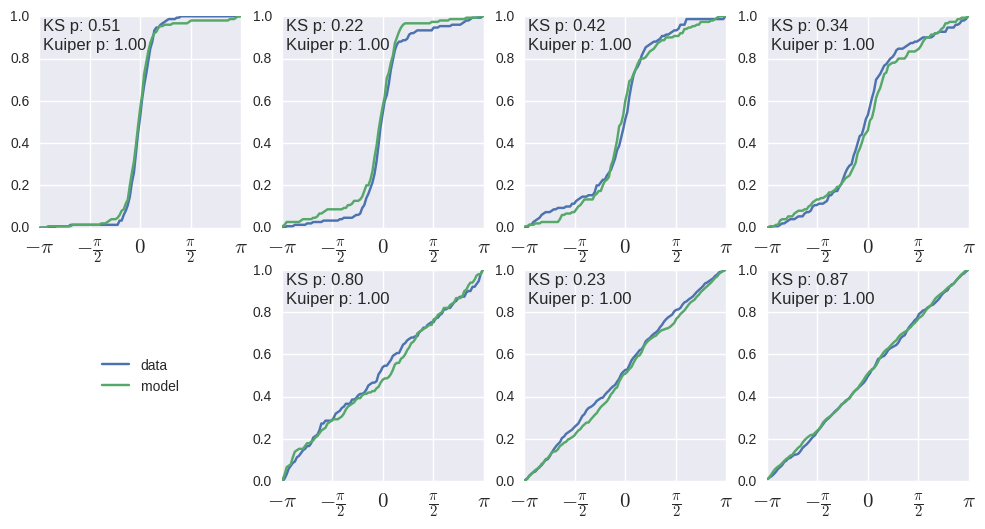

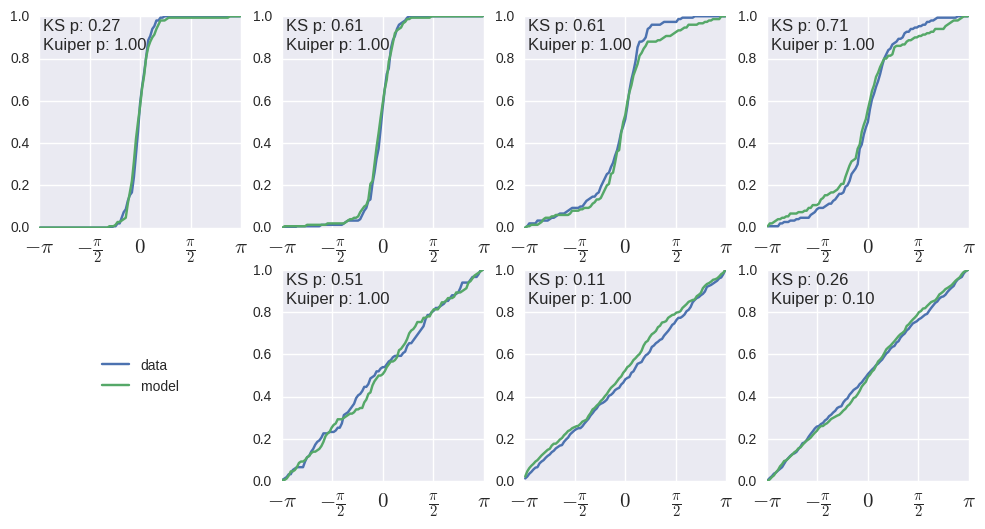

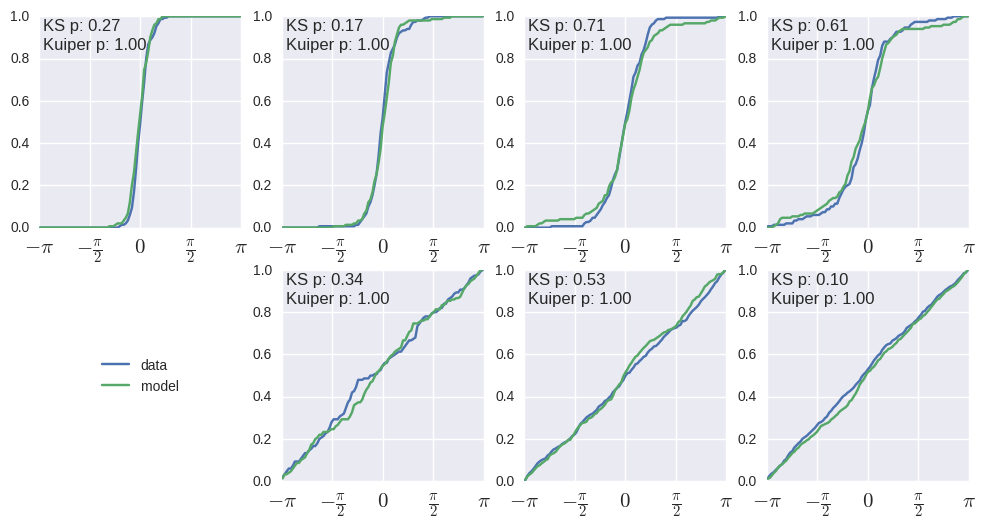

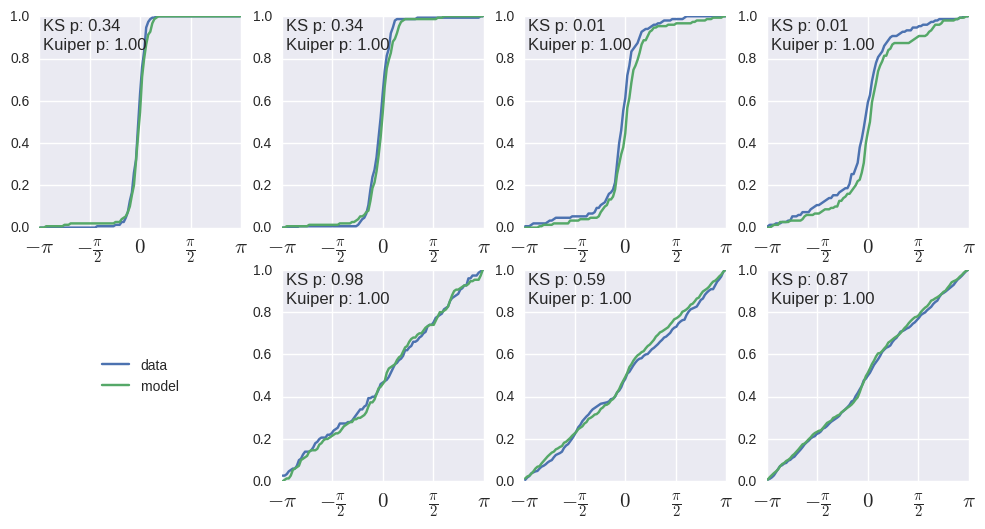

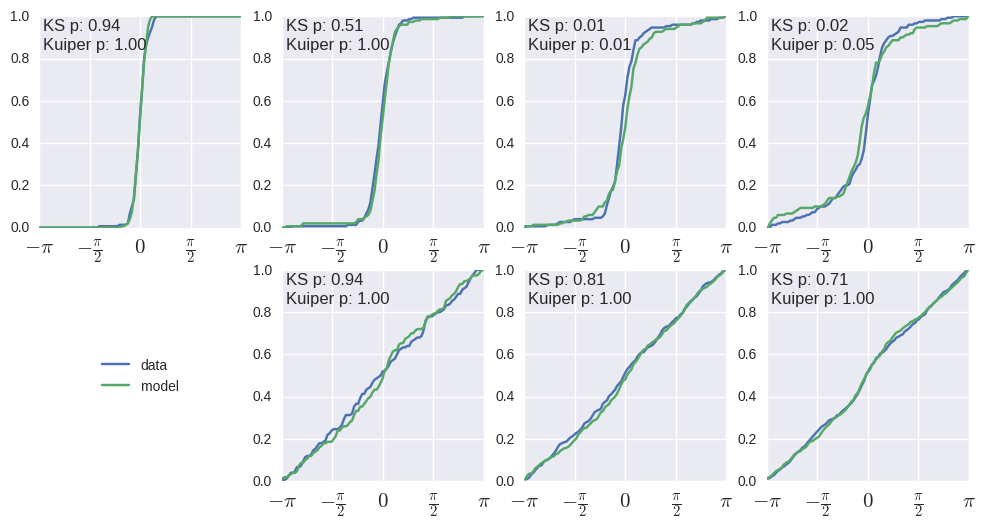

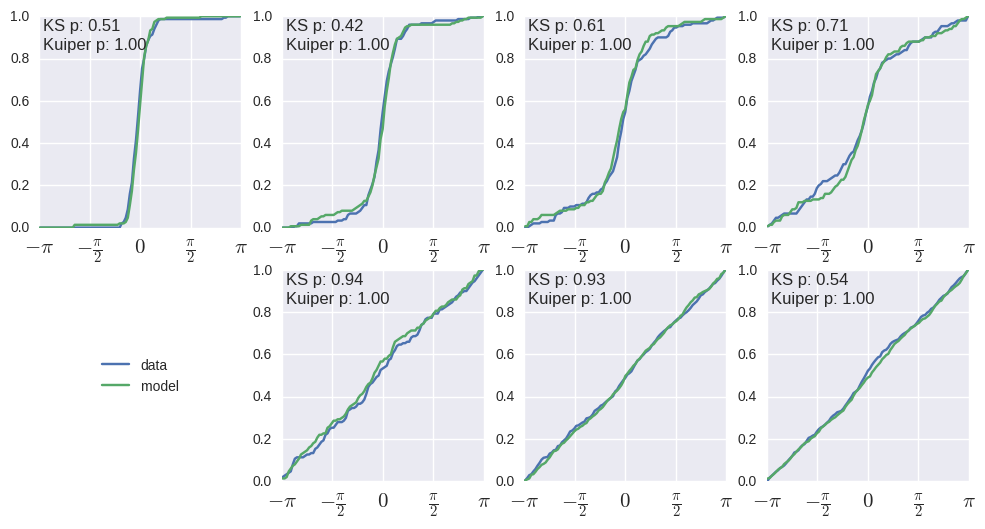

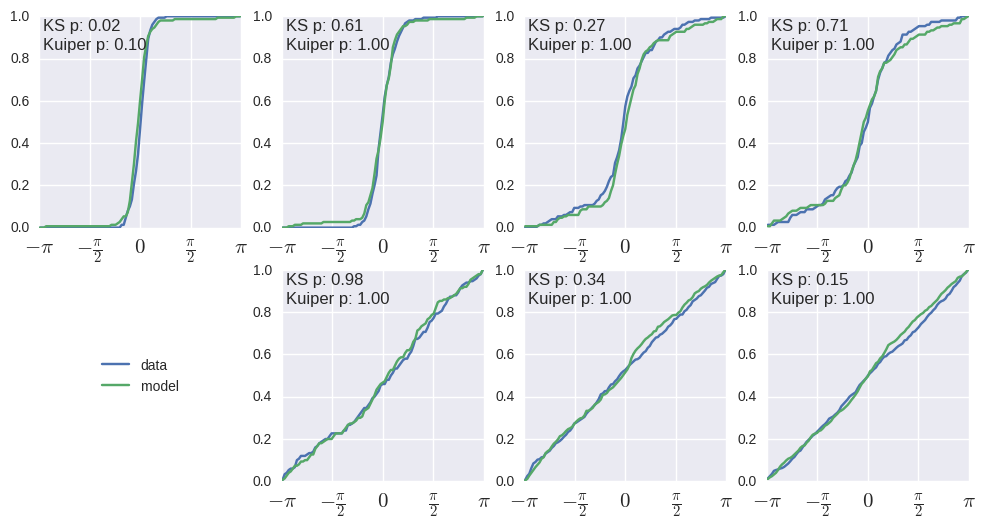

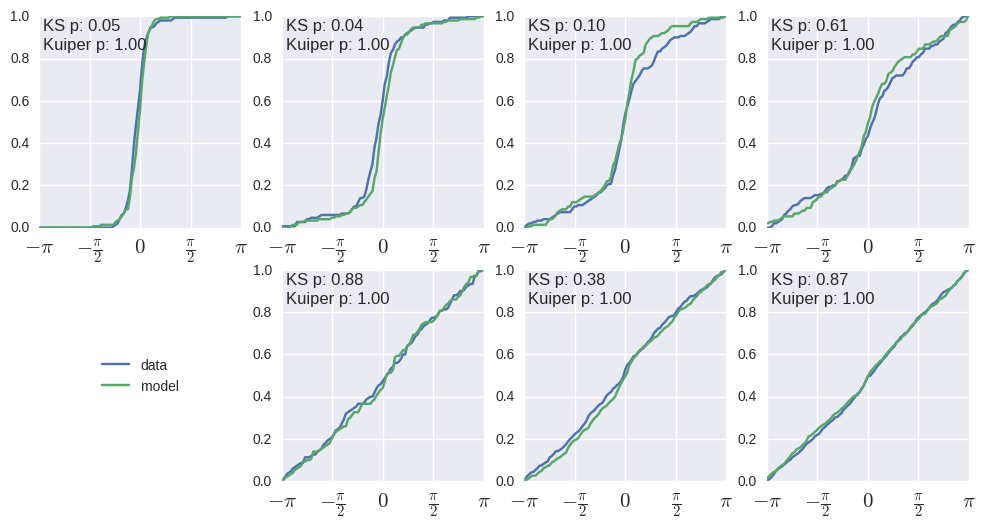

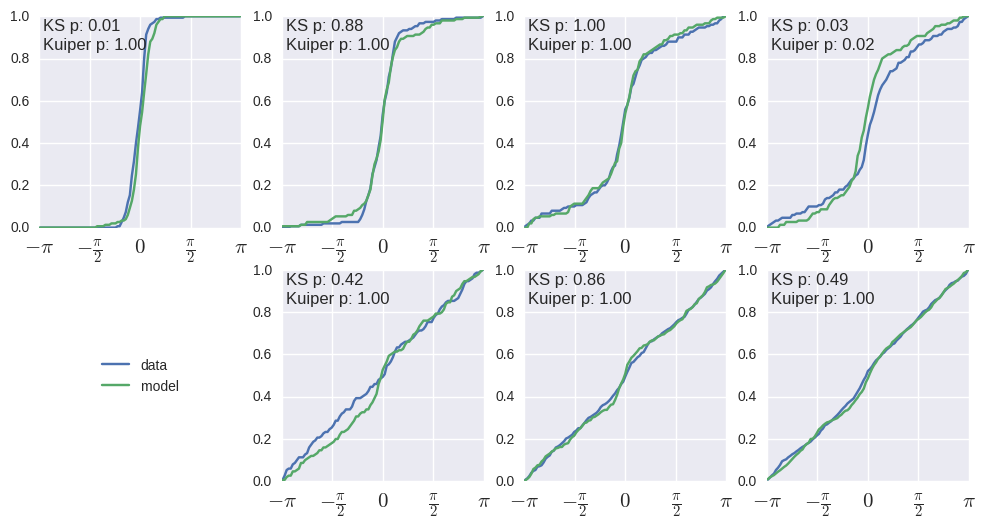

In [16]:
all_histogram_results = dict()
all_axes_cdf = dict()

for subject in progress.ProgressDisplay(subject_space_sorted_bis):
    print "Subject %d" % subject
    with io.capture_output(display=False, stderr=False) as captured:
        all_axes_cdf[subject], all_histogram_results[subject] = all_plots_fit_exp[subject].plots_KS_comparison_fig2fig5(bins=100)
        # all_axes_cdf[subject][0, 0].set_ylabel('Subject %d' % subject, fontsize=30)
#         all_axes_cdf[subject][0, 0].set_title('Subject %d' % subject, fontsize=30)
        all_axes_cdf[subject][0, 0].figure.suptitle('')
        


In [17]:
T_space = np.sort(all_histogram_results[subject]['kuiper_pval'].keys())

str_out = ""
for subject in progress.ProgressDisplay(subject_space_sorted_bis):
    count_significant = 0
    str_out = str_out + "S:%3d | " % subject
    for condition in ['targets', 'nontargets']:
        for T, data in all_histogram_results[subject]['kuiper_pval'].iteritems():
            if condition in data:
                str_out = str_out + "%.3f " % data[condition]
                if data[condition] > 0.05:
                    count_significant += 1
        
        str_out = str_out + " | "
    
    str_out = str_out + " => %d good" % count_significant
    str_out = str_out + '\n'
print str_out

[0%] --
[8%] 0s
[16%] 0s
[25%] 0s
[33%] 0s
[41%] 0s
[50%] 0s
[58%] 0s
[66%] 0s
[75%] 0s
[83%] 0s
[91%] 0s
[100%] 0s
S: 12 | 1.000 1.000 1.000 1.000  | 1.000 1.000 1.000  |  => 7 good
S:  8 | 1.000 1.000 1.000 1.000  | 1.000 1.000 1.000  |  => 7 good
S: 10 | 1.000 1.000 1.000 1.000  | 1.000 1.000 1.000  |  => 7 good
S:  9 | 1.000 1.000 1.000 1.000  | 1.000 1.000 1.000  |  => 7 good
S:  7 | 1.000 1.000 1.000 1.000  | 1.000 1.000 0.100  |  => 7 good
S:  3 | 1.000 1.000 1.000 1.000  | 1.000 1.000 1.000  |  => 7 good
S:  6 | 1.000 1.000 1.000 1.000  | 1.000 1.000 1.000  |  => 7 good
S:  4 | 1.000 1.000 0.010 0.050  | 1.000 1.000 1.000  |  => 5 good
S:  2 | 1.000 1.000 1.000 1.000  | 1.000 1.000 1.000  |  => 7 good
S:  1 | 0.100 1.000 1.000 1.000  | 1.000 1.000 1.000  |  => 7 good
S:  5 | 1.000 1.000 1.000 1.000  | 1.000 1.000 1.000  |  => 7 good
S: 11 | 1.000 1.000 1.000 0.020  | 1.000 1.000 1.000  |  => 6 good



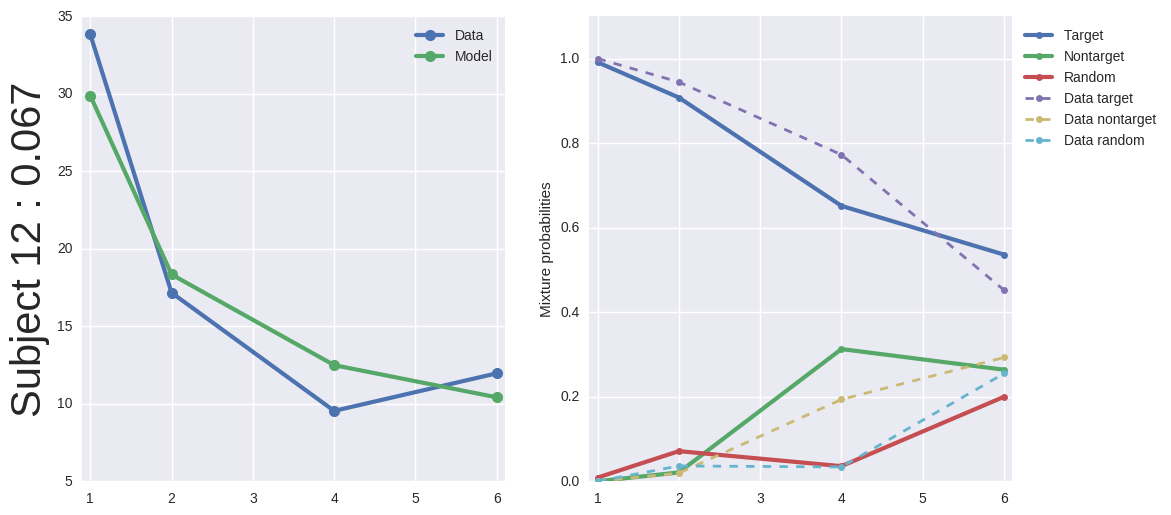

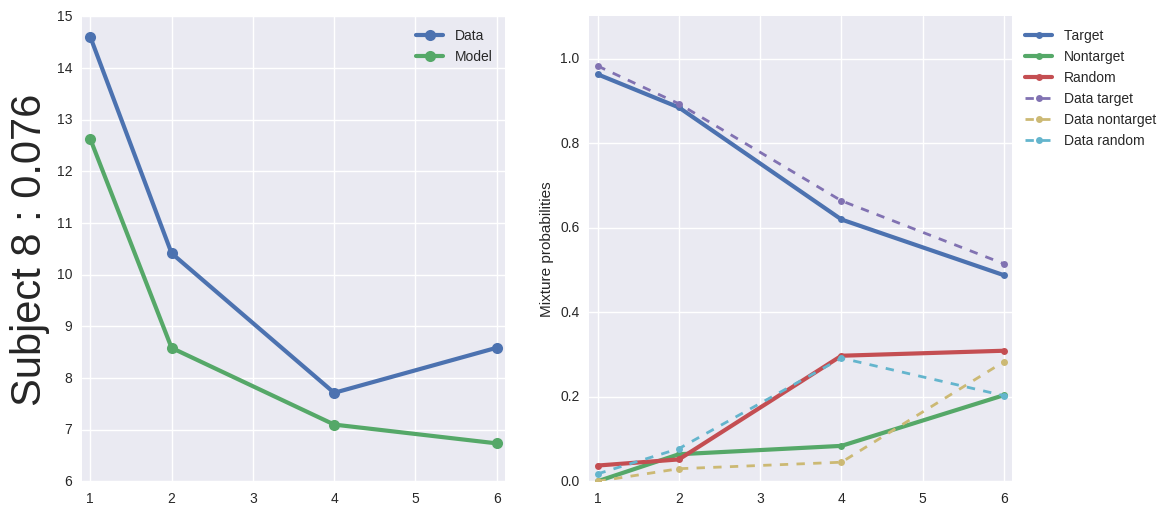

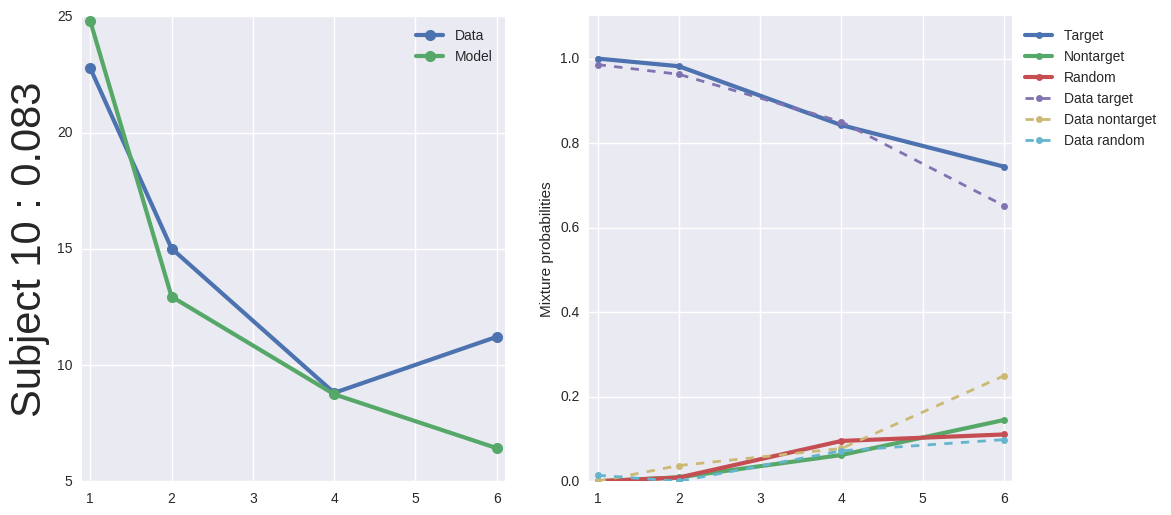

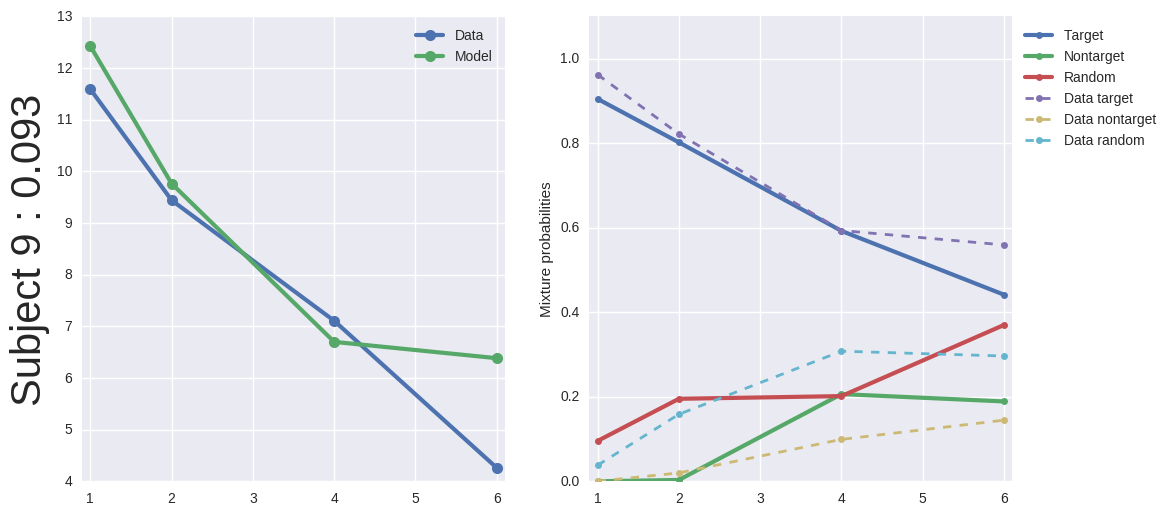

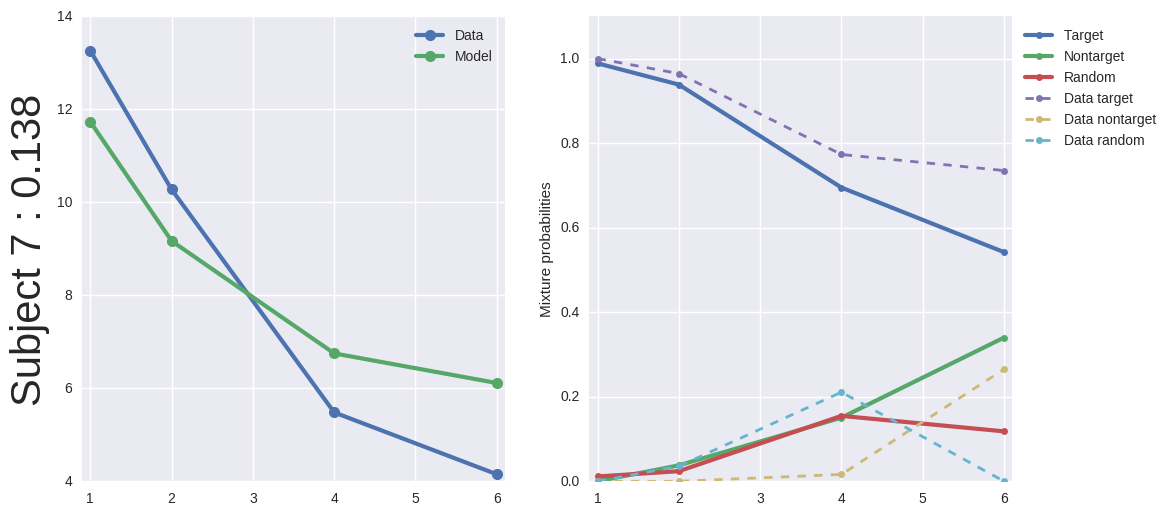

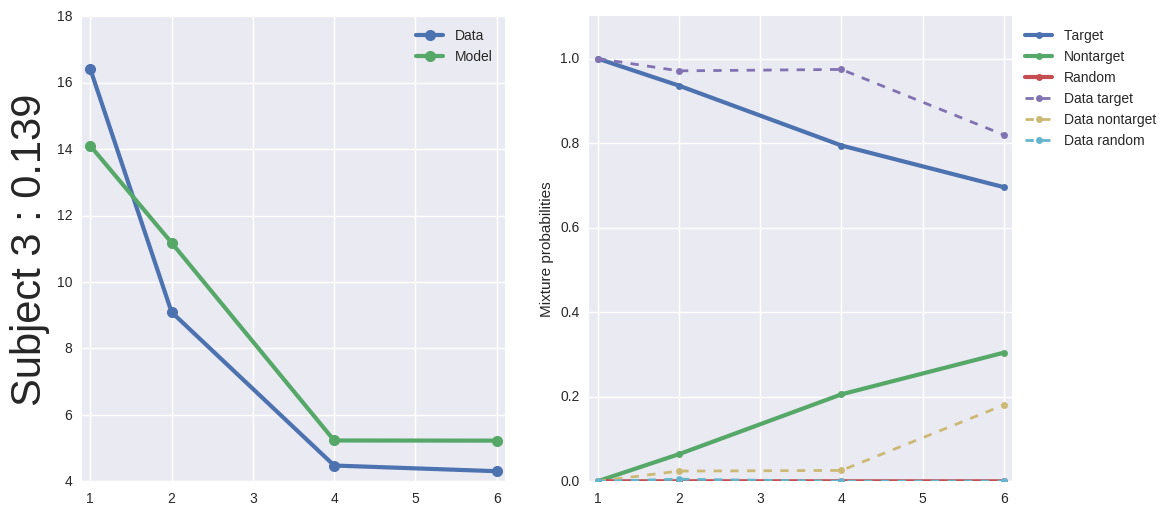

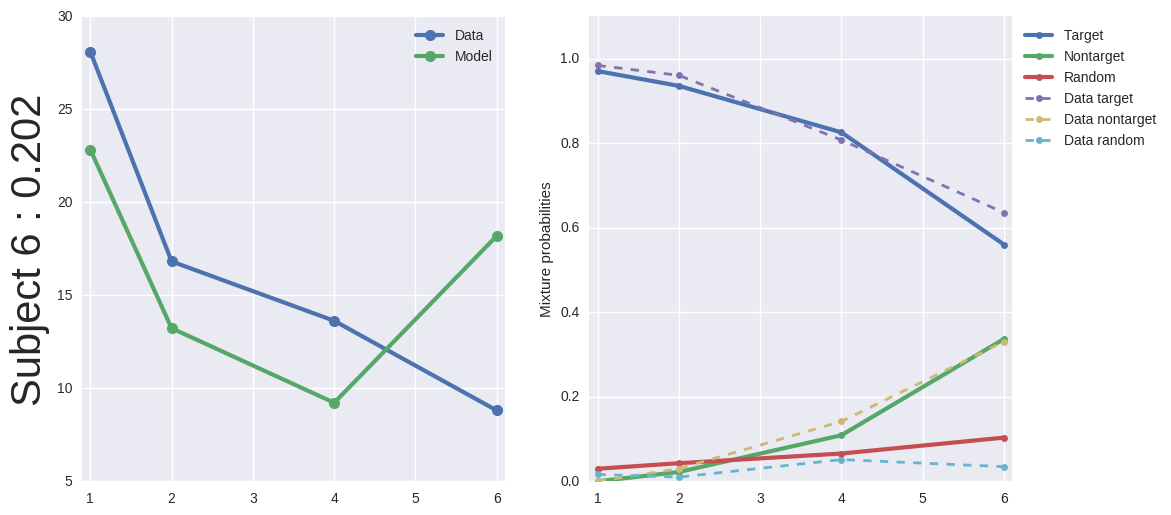

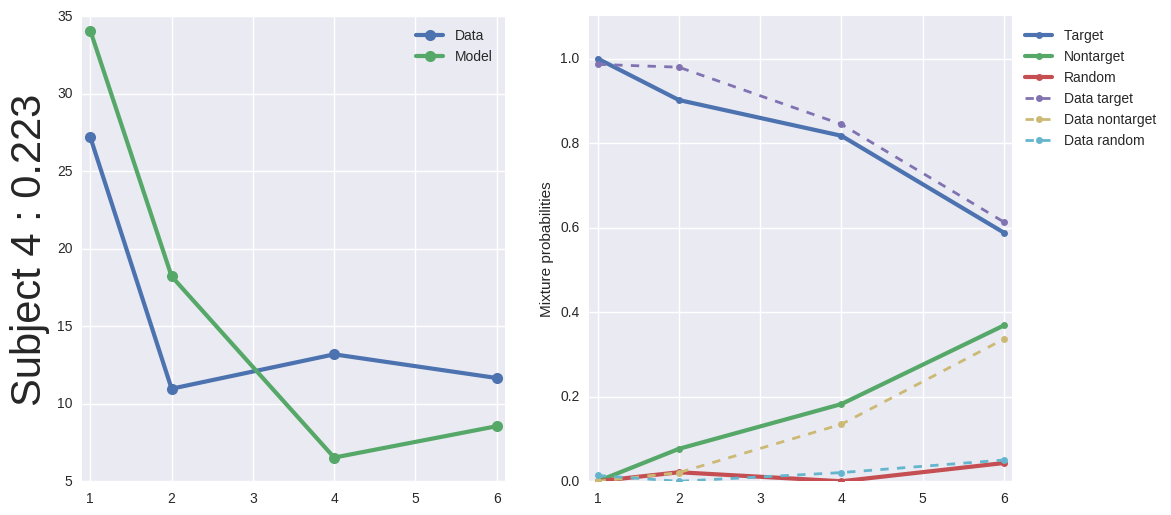

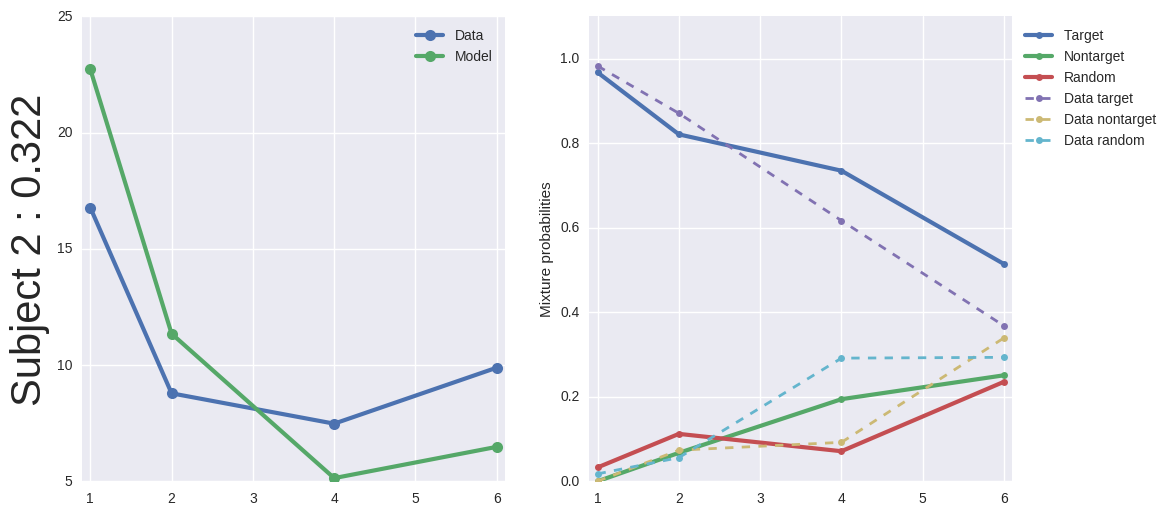

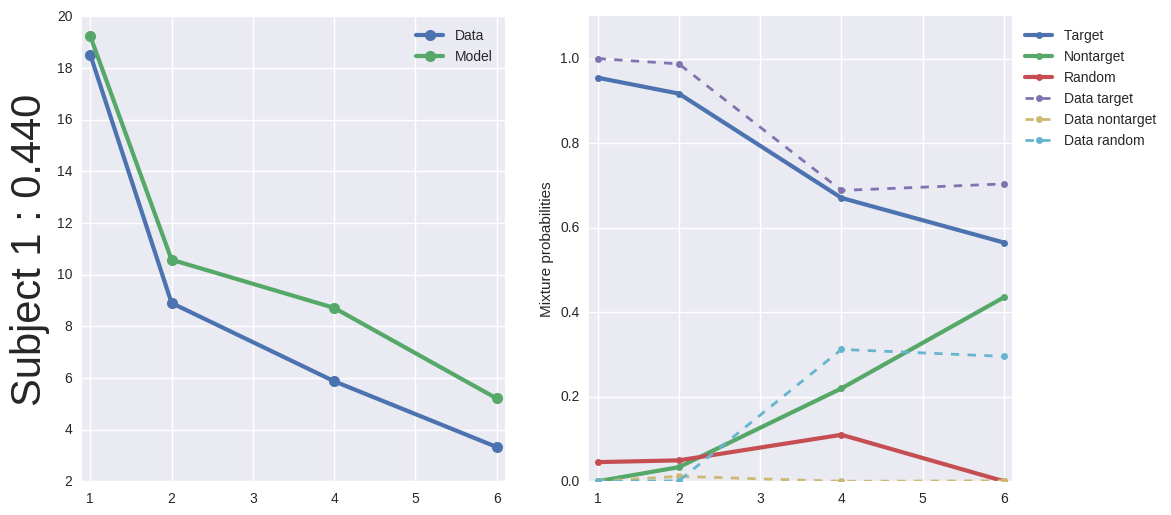

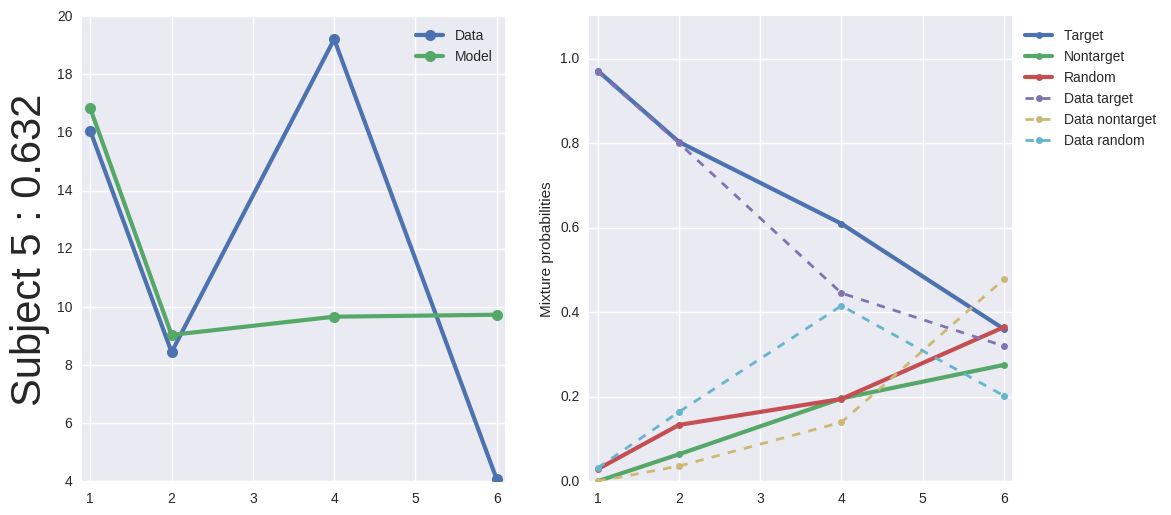

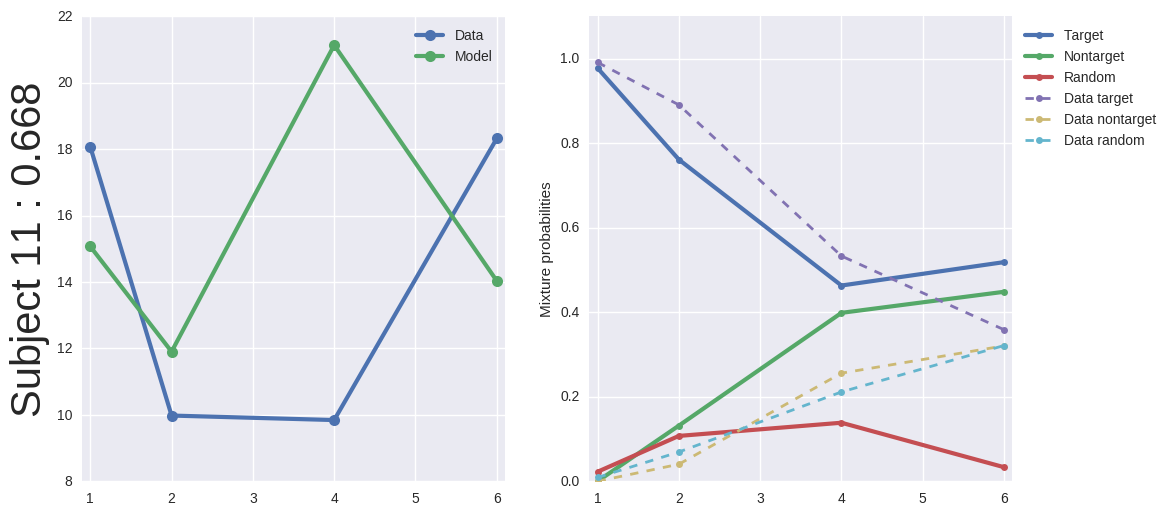

In [18]:
subj_fits_axes = dict()
with io.capture_output(display=False) as captured:
    for subject in subject_space_sorted_bis:
        subj_fits_axes[subject] = all_plots_fit_exp[subject].plots_memmixtcurves_fig6fig13(num_repetitions=1, 
                                                                        use_cache=True, 
                                                                        layout='horizontal')
        subj_fits_axes[subject][0].set_ylabel(
            'Subject %d : %.3f' % (subject, dist_emfitscaled_subjects[subject-1]), fontsize=30)
        subj_fits_axes[subject][0].set_title('')
        subj_fits_axes[subject][1].set_title('')
        subj_fits_axes[subject][0].set_xlabel('')
        subj_fits_axes[subject][1].set_xlabel('')

## Checking if average of parameters gives a good fit to the overall dataset

In [19]:
# Compute average parameter
df_avgparams_subjects = df_bestparams_subjects.median()
df_avgparams_subjects

step                       2069.000000
experiment_subject            6.500000
dist_emfit_scaled             0.127083
M                           148.500000
lapse_rate                    0.001716
ratio_conj                    0.835407
sigma_baseline                0.264922
sigmax                        0.215996
dist_emfit_scaled_log        -2.063115
dist_emfit_scaled_log10      -0.895999
dtype: float64

In [20]:
experiment_parameters = dict(action_to_do='launcher_do_fitexperiment_allmetrics',
                             inference_method='none',
                             experiment_id='bays09',
                             selection_method='last',
                             renormalize_sigma=None,
                             sigmay=0.00001,
                             num_samples=100,
                             code_type='mixed',
                             slice_width=0.07,
                             burn_samples=100,
                             ratio_conj=0.7,
                             stimuli_generation_recall='random',
                             autoset_parameters=None,
                             )

experiment_parameters.update(df_avgparams_subjects)
for key in ['M', 'experiment_subject']:
    experiment_parameters[key] = int(experiment_parameters[key])
    
with io.capture_output(display=False, stderr=True) as captured:
    experiment_launcher = ExperimentLauncher(run=True, arguments_dict=experiment_parameters)
    avgparam_fit_exp = experiment_launcher.all_vars['fit_exp']
    avgparam_results = experiment_launcher.all_vars['all_outputs_data']
    avgparam_plots_fit_exp = PlotsFitExperimentAllTPaperTheo(avgparam_fit_exp)


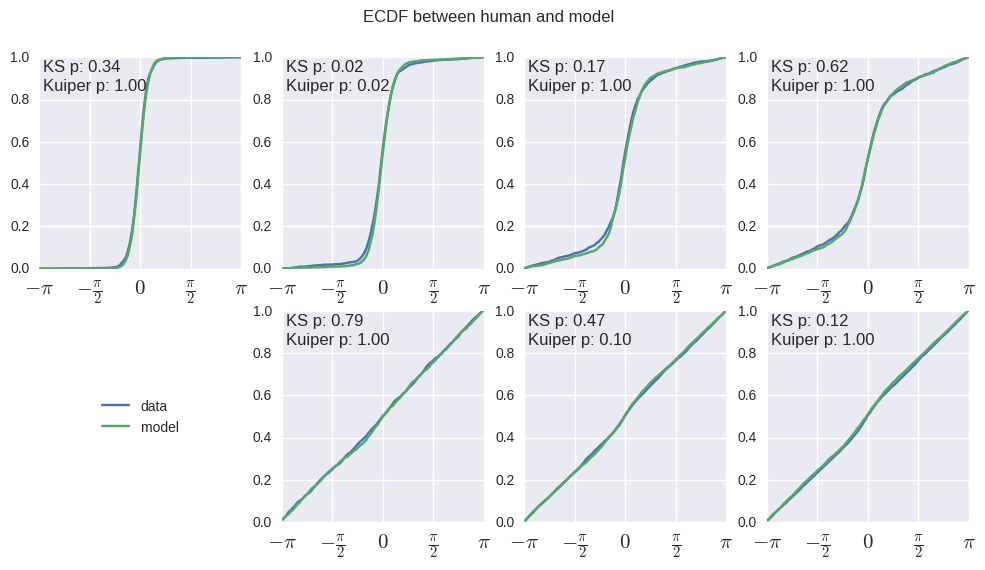

In [21]:
with io.capture_output(display=False) as captured:
    _ = avgparam_plots_fit_exp.plots_KS_comparison_fig2fig5(bins=100)

In [22]:
# with io.capture_output(display=False) as captured:
#     _ = avgparam_plots_fit_exp.plots_memmixtcurves_fig6fig13(num_repetitions=5, use_cache=True)

## Checking averaging the Subjects EM Fits

In [23]:
subjects_em_fits_list = []
for subject in subject_space:
    for T_i, T in enumerate(T_space):
        em_fits_subject = all_results[subject]['result_em_fits'].squeeze()
        subjects_em_fits_list.append(
            dict(subject=subject,
                 T=T,
                 em_kappa=em_fits_subject[T_i, 0],
                 em_target=em_fits_subject[T_i, 1],
                 em_nontarget=em_fits_subject[T_i, 2],
                 em_random=em_fits_subject[T_i, 3],
                 em_ll=em_fits_subject[T_i, 4],
                 em_bic=em_fits_subject[T_i, 5],
                 model_bic=all_results[subject]['result_bic'].squeeze()[T_i],
                 model_ll=all_results[subject]['result_ll_sum'].squeeze()[T_i]
                )
            )

subjects_em_fits_df = pd.DataFrame(subjects_em_fits_list)
subjects_em_fits_df

T      em_bic   em_kappa       em_ll  em_nontarget     em_random  \
0   1   72.358139  19.227246  -26.157799      0.000000  4.532313e-02   
1   2  183.648900  10.575751  -81.803180      0.033411  4.949973e-02   
2   4  361.014631   8.711473 -170.486045      0.219687  1.099920e-01   
3   6  428.114455   5.204462 -204.035957      0.435330  1.581250e-05   
4   1   31.325508  22.722528   -5.641483      0.000000  3.274591e-02   
5   2  253.984047  11.347148 -116.970753      0.067216  1.121232e-01   
6   4  380.204634   5.135989 -180.081046      0.194206  7.111254e-02   
7   6  460.810047   6.480981 -220.383753      0.250736  2.354720e-01   
8   1   54.546327  14.101021  -17.251893      0.000000  5.885436e-08   
9   2  142.073889  11.181894  -61.015674      0.064028  3.115258e-07   
10  4  337.053579   5.228008 -158.505519      0.205689  7.904684e-07   
11  6  384.023809   5.223956 -181.990634      0.304345  9.454955e-07   
12  1  -79.680962  34.079246   49.861751      0.000000  1.138589e-08   
13  2  104.568288  18.223218  -42.262873      0.076758  2.135600e-02   
14  4  300.432990   6.529194 -140.195224      0.182668  3.800162e-05   
15  6  372.878525   8.554891 -176.417992      0.368820  4.321606e-02   
16  1   68.090536  16.827638  -24.023998      0.000000  2.841350e-02   
17  2  289.572422   9.036408 -134.764941      0.063828  1.332786e-01   
18  4  381.247671   9.662448 -180.602565      0.195904  1.947637e-01   
19  6  495.006925   9.730462 -237.482192      0.275349  3.647515e-01   
20  1   25.961341  22.835605   -2.959400      0.000000  2.962527e-02   
21  2  134.817726  13.229316  -57.387593      0.021920  4.275530e-02   
22  4  262.642957   9.220261 -121.300208      0.108999  6.561689e-02   
23  6  332.218201  18.192895 -156.087830      0.336803  1.033074e-01   
24  1  100.587612  11.731472  -40.272535      0.000000  1.134896e-02   
25  2  179.675579   9.168112  -79.816519      0.037723  2.390823e-02   
26  4  379.256734   6.750154 -179.607096      0.150514  1.547165e-01   
27  6  437.716882   6.113250 -208.837170      0.339911  1.180769e-01   
28  1  122.665191  12.624359  -51.311325      0.000000  3.721550e-02   
29  2  235.258437   8.581806 -107.607948      0.063929  5.172043e-02   
30  4  421.798377   7.097394 -200.877918      0.083754  2.969713e-01   
31  6  468.186326   6.733360 -224.071892      0.203803  3.087995e-01   
32  1  181.777568  12.423915  -80.867513      0.000000  9.539722e-02   
33  2  293.635783   9.758239 -136.796621      0.003540  1.946416e-01   
34  4  421.394432   6.698100 -200.675945      0.206225  2.014950e-01   
35  6  489.572221   6.382344 -234.764840      0.188853  3.698358e-01   
36  1  -31.290773  24.785905   25.666657      0.000000  5.260171e-07   
37  2   92.006433  12.940073  -35.981946      0.009317  8.872632e-03   
38  4  270.332076   8.742033 -125.144768      0.062160  9.540070e-02   
39  6  361.427393   6.425165 -170.692426      0.144954  1.108055e-01   
40  1   85.264360  15.069508  -32.610909      0.000000  2.251585e-02   
41  2  266.405118  11.902537 -123.181288      0.131635  1.072983e-01   
42  4  358.202047  21.131200 -169.079753      0.398425  1.384877e-01   
43  6  355.426470  14.033946 -167.691964      0.448273  3.329742e-02   
44  1  -44.343266  29.878759   32.192903      0.000000  8.741756e-03   
45  2  126.193211  18.341150  -53.075335      0.020942  7.128333e-02   
46  4  295.042238  12.491950 -137.499848      0.312772  3.577600e-02   
47  6  415.745972  10.416563 -197.851715      0.263928  1.998729e-01   

    em_target   model_bic    model_ll  subject  
0    0.954677  183.318194  -81.637826        1  
1    0.917089  291.959932 -135.958695        1  
2    0.670321  576.707565 -278.332512        1  
3    0.564654  584.110749 -282.034104        1  
4    0.967254  272.022919 -125.990189        2  
5    0.820661  588.901258 -284.429359        2  
6    0.734682  636.822976 -308.390217        2  
7    0.513792  611.033852 -295.495656        2  
8    1.000000  254.246922 -117.102

In [24]:
# This computes the average fits across subjects. Exactly same as Fig 6!
subjects_pivot = subjects_em_fits_df[['em_kappa', 'em_target', 'em_nontarget', 'em_random', 'T']].groupby('T')

subjectsavg_emfit = dict(
    mean=subjects_pivot.mean().as_matrix(),
    std=subjects_pivot.std().as_matrix()
)

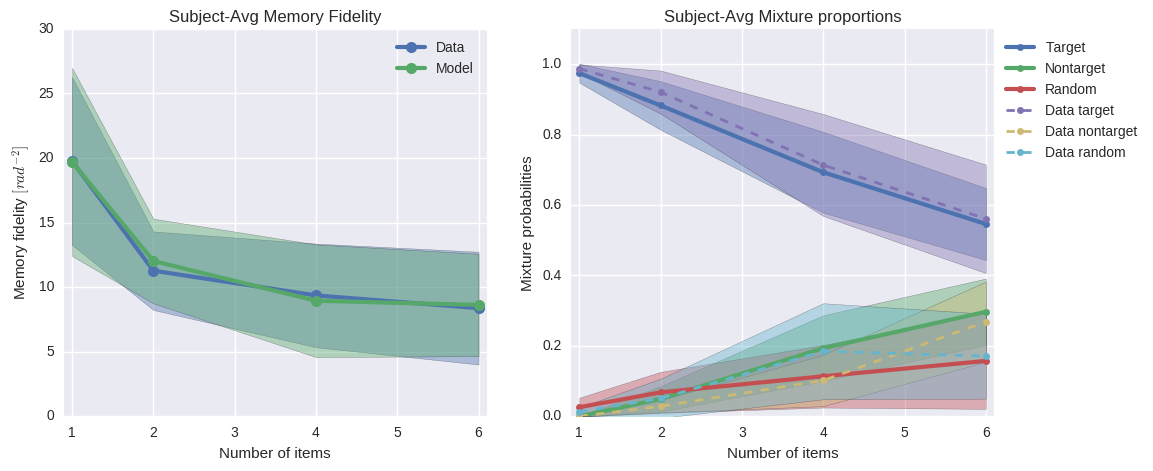

In [25]:
_, subj_avgfit = plt.subplots(1, 2, figsize=(12, 5))
avgparam_plots_fit_exp._PlotsFitExperimentAllTPaperTheo__plot_memcurves(subjectsavg_emfit, suptitle_text="Subject-Avg Memory Fidelity", ax=subj_avgfit[0])
avgparam_plots_fit_exp._PlotsFitExperimentAllTPaperTheo__plot_mixtcurves(subjectsavg_emfit, suptitle_text="Subject-Avg Mixture proportions", ax=subj_avgfit[1])

# ANALYSE ME



In [26]:
# Store figures
dataio = DataIO(output_folder=os.path.join(os.path.abspath("."), "outputs"), 
                label='thesis_subject_bays09_emfitscaled', calling_function='')
dataio.make_link_output_to_dropbox(dropbox_current_experiment_folder='fitexperiment_subject_cmaes_08_2016')

=== FileIO ready: /nfs/data3/lmatthey/visual_working_mem/fitexperiment_subject_cmaes_08_2016/4try_b09_emfit/outputs/thesis_subject_bays09_emfitscaled-7ea09bf0-d0dd-4509-a279-fe7d29c04591 ===
Doing dropbox symlink:  /nfs/data3/lmatthey/visual_working_mem/fitexperiment_subject_cmaes_08_2016/4try_b09_emfit/outputs /nfs/nhome/live/lmatthey/Dropbox/UCL/1-phd/Work/Visual_working_memory/code/git-bayesian-visual-working-memory/Experiments/fitexperiment_subject_cmaes_08_2016/fitexperiment_subject_cmaes_08_2016_4try_b09_emfit
Symlink failed:  /nfs/data3/lmatthey/visual_working_mem/fitexperiment_subject_cmaes_08_2016/4try_b09_emfit/outputs /nfs/nhome/live/lmatthey/Dropbox/UCL/1-phd/Work/Visual_working_memory/code/git-bayesian-visual-working-memory/Experiments/fitexperiment_subject_cmaes_08_2016/fitexperiment_subject_cmaes_08_2016_4try_b09_emfit


In [27]:
# Subject-Avg fits
subj_avgfit[0].figure.savefig(dataio.create_formatted_filename("subjectavg_{label}_{unique_id}.pdf"))

In [28]:
# Subjects fits
for subj, sub_axes in subj_fits_axes.iteritems():
    sub_axes[0].figure.savefig(dataio.create_formatted_filename("subject_%d_emfits_{label}_{unique_id}.pdf" % subj))

In [42]:
# Parameters
fig_parameters.savefig(dataio.create_formatted_filename("barplot_params_{label}_{unique_id}.pdf"))

In [30]:
# CDF
for subj, sub_axes in all_axes_cdf.iteritems():
    sub_axes[0, 0].figure.savefig(dataio.create_formatted_filename("cdf_subject_%d_{label}_{unique_id}.pdf" % subj), 
                                  bbox_inches='tight')